<a href="https://colab.research.google.com/github/sehee020512/20242R0136COSE47402/blob/master/final%20project%2012.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [1]:
!pip install pillow
!pip install transformers
!pip install matplotlib

In [2]:
import kagglehub
import shutil
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.nn as nn
import timm
import torchvision
import torchvision.transforms as T
from sklearn.metrics import accuracy_score
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [3]:
path = kagglehub.dataset_download("kavyasreeb/hair-type-dataset")

print("Path to dataset files:", path)

100%|██████████| 175M/175M [00:08<00:00, 21.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1


In [4]:
# 원본 데이터 경로
source_path = "/root/.cache/kagglehub/datasets/kavyasreeb/hair-type-dataset/versions/1"

# 복사할 대상 경로
destination_path = "/content/hair-type-dataset"

# 데이터 복사
try:
    shutil.copytree(source_path, destination_path)
    print(f"데이터가 {destination_path}에 복사되었습니다.")
except Exception as e:
    print(f"복사 실패: {e}")

데이터가 /content/hair-type-dataset에 복사되었습니다.


In [5]:
# 데이터 경로 설정
dataset_dir = "/content/hair-type-dataset/data"  # 클래스별 이미지가 있는 디렉토리
train_dir = "/content/train"  # train 데이터 저장 경로
test_dir = "/content/test"  # test 데이터 저장 경로

# train/test 디렉토리 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 이미지 확장자 필터
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# 클래스별 train/test 데이터 분리
split_ratio = 0.8  # Train 80%, Test 20%
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    if not os.path.isdir(category_path):
        continue  # 디렉토리가 아니면 건너뜀

    # 클래스별 이미지 파일 가져오기
    images = [img for img in os.listdir(category_path) if img.lower().endswith(valid_extensions)]

    # 이미지가 없으면 건너뜀
    if len(images) == 0:
        print(f"'{category}' 폴더에 이미지가 없습니다. 건너뜁니다.")
        continue

    # train/test로 분리
    train_images, test_images = train_test_split(images, test_size=1 - split_ratio, random_state=42)

    # 클래스별 train/test 디렉토리 생성
    train_category_dir = os.path.join(train_dir, category)
    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(test_category_dir, exist_ok=True)

    # train 이미지 이동
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))

    # test 이미지 이동
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

    print(f"'{category}' 클래스에서 Train: {len(train_images)}개, Test: {len(test_images)}개 파일이 이동되었습니다.")

print("Train/Test 데이터 분리가 완료되었습니다!")

'Straight' 클래스에서 Train: 388개, Test: 97개 파일이 이동되었습니다.
'curly' 클래스에서 Train: 411개, Test: 103개 파일이 이동되었습니다.
'kinky' 클래스에서 Train: 173개, Test: 44개 파일이 이동되었습니다.
'Wavy' 클래스에서 Train: 263개, Test: 66개 파일이 이동되었습니다.
'dreadlocks' 클래스에서 Train: 354개, Test: 89개 파일이 이동되었습니다.
Train/Test 데이터 분리가 완료되었습니다!


In [6]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # DeiT 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Fine-Tuning w/o Freezing

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

model.head = nn.Linear(model.head.in_features, 5)

torch.nn.init.xavier_uniform_(model.head.weight)
torch.nn.init.zeros_(model.head.bias)

print(model)

In [ ]:
# 동결된 파라미터와 학습 가능한 파라미터 확인
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
# device 설정: GPU가 사용 가능하면 GPU, 아니면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)  # 모델을 지정된 device로 이동

In [ ]:
test_images = []
test_labels = []  # 실제 레이블 저장
predicted_labels = []  # 예측된 레이블 저장

# 하위 폴더를 순회하며 이미지와 레이블을 로드
try:
    label_mapping = {label: idx for idx, label in enumerate(sorted(os.listdir(test_dir)))}
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.lower().endswith(valid_extensions):  # 유효한 이미지 파일인지 확인
                try:
                    # 폴더 이름을 레이블로 사용
                    label = label_mapping[category]
                    test_labels.append(label)

                    # 이미지 열기 및 전처리
                    img = Image.open(file_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0).to(device)  # 배치 차원 추가

                    # 모델 예측
                    with torch.no_grad():
                        output = model(img_tensor)
                        predicted_class = torch.argmax(output, dim=1).item()

                    # 예측된 레이블 저장
                    predicted_labels.append(predicted_class)
                except Exception as e:
                    print(f"이미지 처리 실패: {file_name}, 오류: {e}")
except Exception as e:
    print(f"테스트 데이터 로드 중 오류 발생: {e}")

# 4. 정확도 계산 및 출력
if test_labels and predicted_labels:
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"테스트 데이터 개수: {len(test_labels)}")
    print(f"정확도: {accuracy * 100:.2f}%")

    # 예측 결과 예시 출력
    for i in range(len(test_labels)):
        true_label = reverse_mapping[test_labels[i]]
        predicted_label = reverse_mapping[predicted_labels[i]]
else:
    print("테스트 데이터가 비어 있거나 예측 결과가 없습니다.")

In [ ]:
img_tensor = img_tensor.to(device)  # 이미지를 동일한 device로 이동

In [ ]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 (옵션)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
import time  # 시간을 측정하기 위한 모듈

num_epochs = 10  # 에포크 수

for epoch in range(num_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    # 모델 학습 모드
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 및 손실 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 옵티마이저 업데이트
        loss.backward()
        optimizer.step()

        # 손실과 정확도 업데이트
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # 에포크 종료 시간 기록
    end_time = time.time()
    epoch_duration = end_time - start_time  # 에포크 소요 시간 계산

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100.*correct/total:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # 학습률 스케줄러 업데이트 (옵션)
    scheduler.step()

# 학습 완료
print("Fine-Tuning 완료!")

In [ ]:
# Hook 함수 정의
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

# Transformer 블록에 Hook 등록
for i in range(0, 12):
  model.blocks[i].register_forward_hook(hook_fn)

# 모델 추론
with torch.no_grad():
    _ = model(img_tensor)

# 블록별 Feature Map 출력
for i, feature_map in enumerate(feature_maps):

In [ ]:
# Feature Maps 시각화
num_blocks = len(feature_maps)  # Transformer 블록의 수
fig, axes = plt.subplots(1, num_blocks, figsize=(20, 5))  # 가로로 블록 수만큼의 서브플롯 생성

for i, (ax, block_feature_map) in enumerate(zip(axes, feature_maps)):
    # 클래스 토큰 제거
    block_feature_map_patches = block_feature_map[0, 1:, :]  # 배치 차원 0 제거, [1, 197, 768] → [196, 768]

    # 14x14 형태로 변환
    patch_size = int(block_feature_map_patches.size(0) ** 0.5)  # 14
    feature_map_2d = block_feature_map_patches.view(patch_size, patch_size, -1)

    # 평균값으로 축소하여 시각화
    feature_map_avg = feature_map_2d.mean(axis=-1).cpu().detach().numpy()

    # 서브플롯에 Feature Map 시각화
    ax.imshow(feature_map_avg, cmap='viridis')
    ax.set_title(f"Block {i}")
    ax.axis("off")  # 축 제거

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

In [ ]:
# 모델 평가 모드
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"테스트 데이터 정확도: {100.*correct/total:.2f}%")

## Fine-Tuning w/ Freezing

In [7]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

model.head = nn.Linear(model.head.in_features, 5)

torch.nn.init.xavier_uniform_(model.head.weight)
torch.nn.init.zeros_(model.head.bias)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/f

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [8]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 (옵션)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 동결된 파라미터와 학습 가능한 파라미터 확인
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"{name}: requires_grad={param.requires_grad}")

In [9]:
# device 설정: GPU가 사용 가능하면 GPU, 아니면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)  # 모델을 지정된 device로 이동

Using device: cuda


In [10]:
test_images = []
test_labels = []  # 실제 레이블 저장
predicted_labels = []  # 예측된 레이블 저장

# 하위 폴더를 순회하며 이미지와 레이블을 로드
try:
    label_mapping = {label: idx for idx, label in enumerate(sorted(os.listdir(test_dir)))}
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if not os.path.isdir(category_path):
            continue

        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if file_name.lower().endswith(valid_extensions):  # 유효한 이미지 파일인지 확인
                try:
                    # 폴더 이름을 레이블로 사용
                    label = label_mapping[category]
                    test_labels.append(label)

                    # 이미지 열기 및 전처리
                    img = Image.open(file_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0).to(device)  # 배치 차원 추가

                    # 모델 예측
                    with torch.no_grad():
                        output = model(img_tensor)
                        predicted_class = torch.argmax(output, dim=1).item()

                    # 예측된 레이블 저장
                    predicted_labels.append(predicted_class)
                except Exception as e:
                    print(f"이미지 처리 실패: {file_name}, 오류: {e}")
except Exception as e:
    print(f"테스트 데이터 로드 중 오류 발생: {e}")

# 4. 정확도 계산 및 출력
if test_labels and predicted_labels:
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"테스트 데이터 개수: {len(test_labels)}")
    print(f"정확도: {accuracy * 100:.2f}%")

    # 예측 결과 예시 출력
    for i in range(len(test_labels)):
        true_label = reverse_mapping[test_labels[i]]
        predicted_label = reverse_mapping[predicted_labels[i]]
else:
    print("테스트 데이터가 비어 있거나 예측 결과가 없습니다.")

테스트 데이터 개수: 399
정확도: 24.31%


In [11]:
img_tensor = img_tensor.to(device)  # 이미지를 동일한 device로 이동

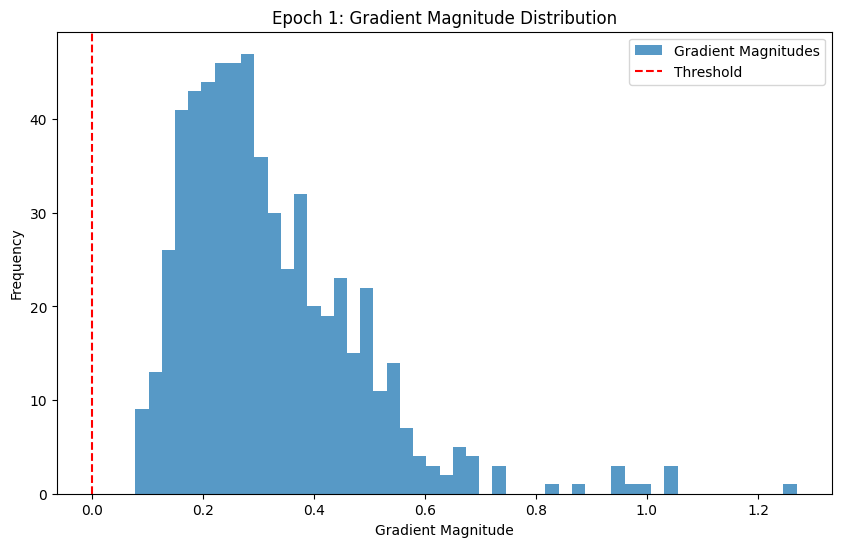

Epoch [1], Loss: 0.5771, Accuracy: 76.53%, Duration: 25.65 seconds


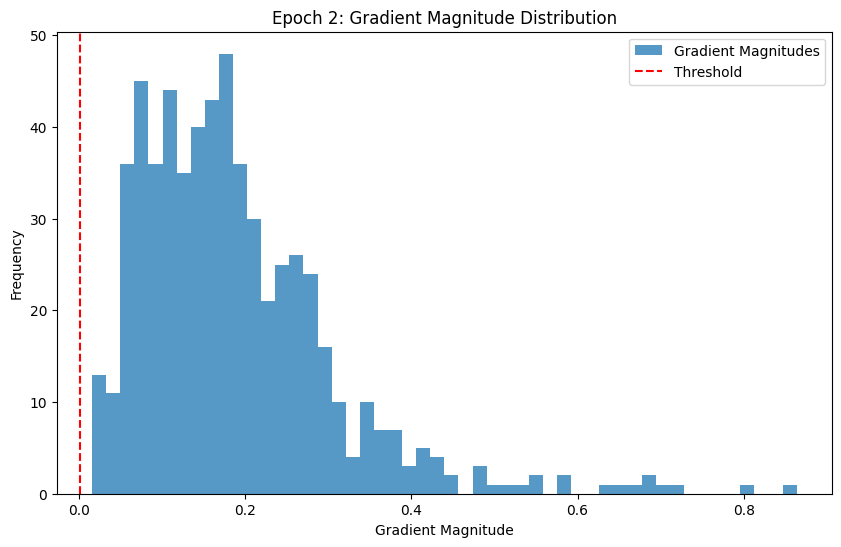

Epoch [2], Loss: 0.1422, Accuracy: 95.03%, Duration: 24.59 seconds


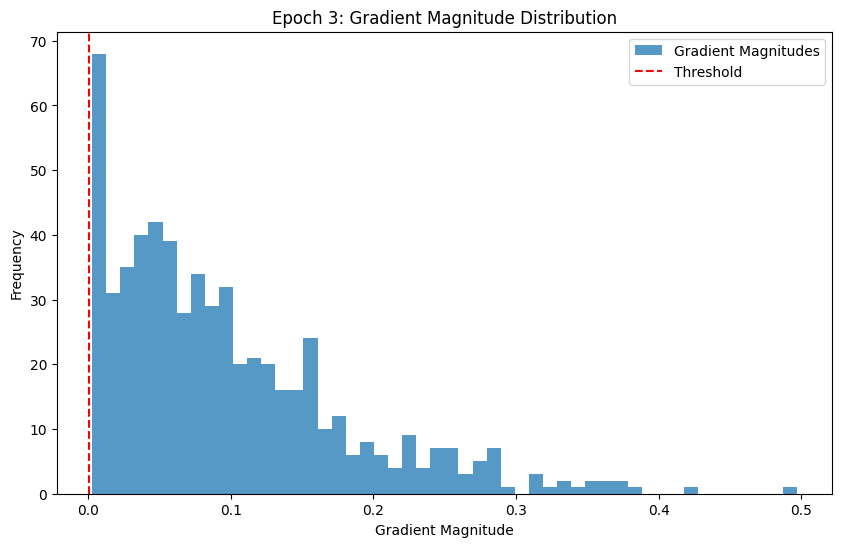

Epoch [3], Loss: 0.0553, Accuracy: 98.36%, Duration: 24.58 seconds


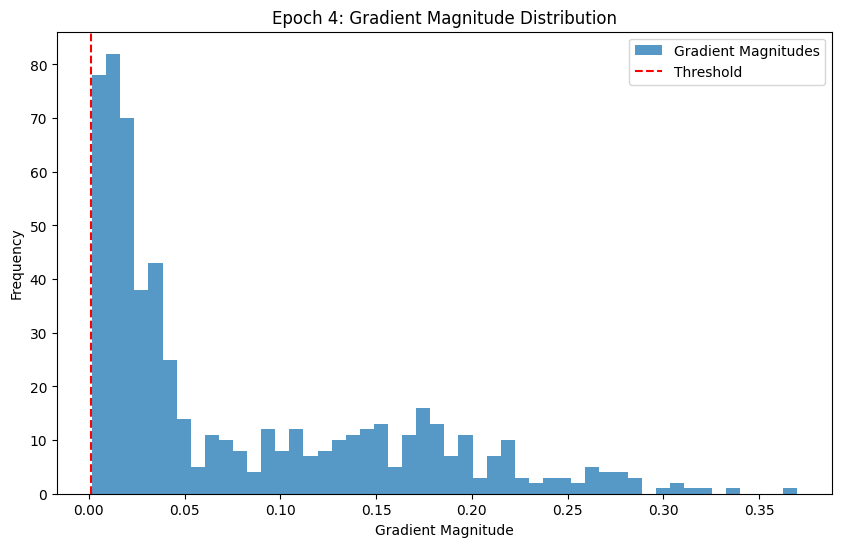

Epoch [4], Loss: 0.0446, Accuracy: 98.62%, Duration: 24.59 seconds
Block 1 is frozen (Gradient: 0.000783).
Block 2 is frozen (Gradient: 0.000913).
Block 3 is frozen (Gradient: 0.000986).
Block 5 is frozen (Gradient: 0.000981).
Block 10 is frozen (Gradient: 0.000987).
Block 11 is frozen (Gradient: 0.000688).
Block 0 is frozen (Gradient: 0.000535).
Block 4 is frozen (Gradient: 0.000363).
Block 6 is frozen (Gradient: 0.000375).
Block 7 is frozen (Gradient: 0.000403).
Block 8 is frozen (Gradient: 0.000457).
Block 9 is frozen (Gradient: 0.000488).


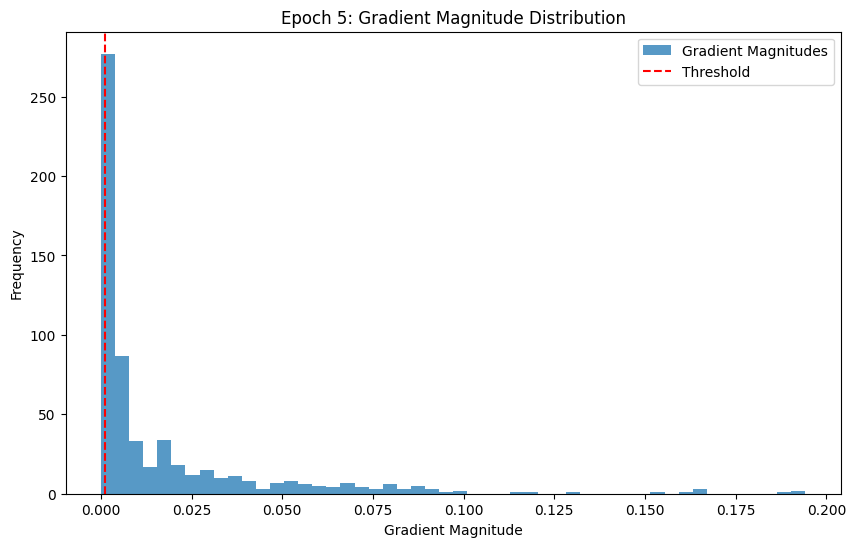

Epoch [5], Loss: 0.0120, Accuracy: 99.62%, Duration: 23.33 seconds
All blocks are frozen. Training stopped at Epoch 5.
Fine-Tuning 완료!


In [12]:
def log_gradients_and_freeze(model, freeze_threshold):
    gradient_logs = []  # 각 블록의 Gradient 정보를 저장
    all_frozen = True  # 모든 블록이 frozen 상태인지 확인

    for idx, block in enumerate(model.blocks):
        # 이미 frozen된 블록은 건너뜀
        if not any(param.requires_grad for param in block.parameters()):
            gradient_logs.append(0.0)  # Frozen 블록의 Gradient를 0으로 처리
            continue

        # Frozen되지 않은 블록이 존재하면 all_frozen은 False
        all_frozen = False

        total_grad = 0.0
        num_params = 0
        for param in block.parameters():
            if param.grad is not None:
                total_grad += param.grad.norm().item()  # 기울기의 L2 노름 계산
                num_params += 1
        avg_grad = total_grad / max(1, num_params)  # 평균 기울기
        gradient_logs.append(avg_grad)

        # Freezing 조건
        if avg_grad < freeze_threshold:
            for param in block.parameters():
                param.requires_grad = False
            print(f"Block {idx} is frozen (Gradient: {avg_grad:.6f}).")

    return gradient_logs, all_frozen


# 학습 루프
freeze_threshold = 1e-3  # 블록을 freezing할 기울기 크기 임계값
epoch = 0  # 에포크 수 초기화

while True:
    epoch += 1  # 에포크 증가
    start_time = time.time()  # 에포크 시작 시간 기록

    model.train()  # 모델 학습 모드
    running_loss = 0.0
    correct = 0
    total = 0
    max_gradients = []  # 모든 블록의 Gradient Magnitude 기록용 리스트

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 및 손실 계산
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파
        loss.backward()

        # Gradient 크기 로깅 및 Freezing
        gradient_logs, all_frozen = log_gradients_and_freeze(model, freeze_threshold)
        max_gradients.extend(gradient_logs)  # Gradient Magnitudes 누적

        # 옵티마이저 업데이트
        optimizer.step()

        # 손실 및 정확도 계산
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Gradient Magnitude 히스토그램 출력
    plt.figure(figsize=(10, 6))
    plt.hist(max_gradients, bins=50, alpha=0.75, label='Gradient Magnitudes')
    plt.title(f"Epoch {epoch}: Gradient Magnitude Distribution")
    plt.xlabel("Gradient Magnitude")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 에포크 종료 시간 기록
    end_time = time.time()
    epoch_duration = end_time - start_time  # 에포크 소요 시간 계산

    print(f"Epoch [{epoch}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100.*correct/total:.2f}%, Duration: {epoch_duration:.2f} seconds")

    # 학습률 스케줄러 업데이트 (옵션)
    scheduler.step()

    # 모든 블록이 frozen 상태라면 학습 종료
    if all_frozen:
        print(f"All blocks are frozen. Training stopped at Epoch {epoch}.")
        break

# 학습 완료
print("Fine-Tuning 완료!")

In [14]:
# 모델 평가 모드
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"테스트 데이터 정확도: {100.*correct/total:.2f}%")

테스트 데이터 정확도: 92.21%
